# Predic product features from images



# Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = False
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'tensorflow'

# Loading Data

In [ ]:
f = open('input/hm-articlecustomer-embeddings-from-images/article_embeddings_from_image.pickle', 'rb')
embeds = pickle.load(f)
embeds = pd.DataFrame(embeds).reset_index()
embeds.columns = ['article_id', 'embeds']
embeds.embeds = embeds.embeds.map(np.array)

In [ ]:
embeds.head()

In [ ]:
df = pd.read_csv('input/h-and-m-personalized-fashion-recommendations/articles.csv', dtype={'article_id':str})
df = df.select_dtypes(object)
df = df.drop(['index_code', 'detail_desc', 'prod_name'], axis=1)

In [ ]:
df.nunique()

In [ ]:
df = df.merge(embeds, on='article_id')

In [ ]:
df.head()

# Model Building

In [ ]:
def twoLayerFeedForward():
    clf = Sequential()
    clf.add(Dense(1024, activation='relu', input_dim=1000))
    clf.add(Dense(2048, activation='relu'))
    clf.add(Dense(1024, activation='relu'))
    clf.add(Dense(512, activation='relu'))
    clf.add(Dense(1, activation='softmax'))
    clf.compile(loss='BinaryCrossentropy', optimizer='sgd',
                metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    return clf

clf = KerasClassifier(twoLayerFeedForward, epochs=10, batch_size=64, verbose=1)
lr = LR(solver='liblinear')
dt = DT()
rf = RF()
svr = SVC(probability=True)
knn = KNN(10)

models = [lr, dt, rf, svr, knn, clf][:-1]
models_names = ['linear_model', 'descision_tree', 'random_forest', 'SVM', 'KNN', 'keras'][:-1]
metrics = [accuracy_score, precision_score, recall_score]
metrics_names = ['accuracy_score', 'precision_score', 'recall_score']

x = np.array(df['embeds'].to_list())#[:100]

split = int(0.8*len(x))

x_train, x_test = x[:split], x[split:]

# Target variable and Model selection

In [ ]:
target = 'product_type_name'
model, model_name = rf, 'random_forest'

In [ ]:
y = np.array(df[target].to_list())
y_train, y_test = y[:split], y[split:]

# GridSerach

In [ ]:
# param_grid_rf = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

# grid = GridSearchCV(model, grid_params[model_name], refit = True, verbose = 2, n_jobs=-1)

# grid.fit(x_train, y_train)

# best_estimators = grid.best_estimator_
# best_score = grid.best_score_
# best_params = grid.best_params_

# Model training

In [ ]:
model.fit(x_train, y_train)

In [ ]:
train_df = pd.DataFrame({'label': y_train}, index=df.article_id[:split])
test_df = pd.DataFrame({'label': y_test}, index=df.article_id[split:])

test_df['prediction'] = model.predict(x_test).flatten()
train_df['prediction'] = model.predict(x_train).flatten()

# Calculating Metrics

In [ ]:
train_acc = accuracy_score(train_df['prediction'].values.reshape(-1, 1), y_train.reshape(-1, 1))
train_precision = precision_score(train_df['prediction'].values.reshape(-1, 1), y_train.reshape(-1, 1), average='weighted')
train_recall = recall_score(train_df['prediction'].values.reshape(-1, 1), y_train.reshape(-1, 1), average='weighted')

test_acc = accuracy_score(test_df['prediction'].values.reshape(-1, 1), y_test.reshape(-1, 1))
test_precision = precision_score(test_df['prediction'].values.reshape(-1, 1), y_test.reshape(-1, 1), average='weighted')
test_recall = recall_score(test_df['prediction'].values.reshape(-1, 1), y_test.reshape(-1, 1), average='weighted')

In [ ]:
scores = pd.DataFrame({'accuracy':[train_acc, test_acc],
                       'precision':[train_precision, test_precision],
                       'recall':[train_recall, test_recall]}, index=['train', 'test']) 

In [ ]:
scores

In [ ]:
sample_y = pd.DataFrame({'label': y_test}, index=df.article_id[split:])[:1000]
sample_x = x_test[:1000]

In [ ]:
sample_y['prediction'] = model.predict(sample_x)
for label in model.classes_:
    sample_y[f'proba_{label}'] = model.predict_proba(sample_x)[:, np.where(model.classes_ == label)[0][0]].flatten()

In [ ]:
# mask = sample_y.iloc[0].iloc[2:] > 0#.sort_values(ascending=False)
# sample_y.iloc[0].iloc[2:][mask.values].sort_values(ascending=False)

# Testing

In [ ]:
def generate_caption():
    
    fig, axs = plt.subplots(1, 5, figsize=(20,10))
    axs = axs.flatten()
    
    for ax in axs:
        
        sample = sample_y.sample(1)
        img_path = f'input/h-and-m-personalized-fashion-recommendations/images/{sample.index[0][:3]}/{sample.index[0]}.jpg'
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        txt = f'True Label: {sample.label.values[0]} \n Random Forest: {sample.prediction.values[0]}'
        ax.title.set_text(txt)

In [ ]:
generate_caption()

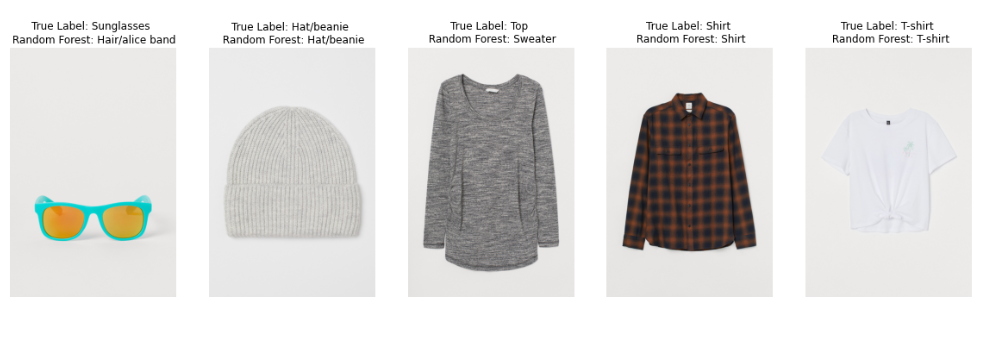

In [ ]:
generate_caption()

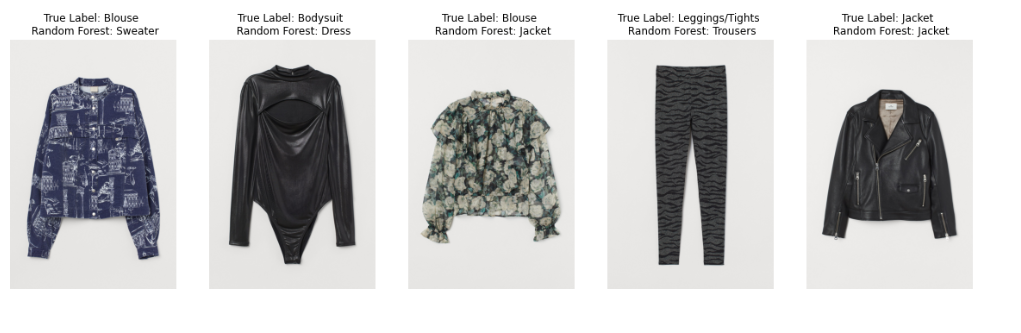

### Saving samples for demonstration

In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
!mkdir images

def plot_items(items):
    path = "input/h-and-m-personalized-fashion-recommendations/images"

    k = len(items)
    for item, i in zip(items, range(1, k+1)):
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = Image.open(image)
       
        basewidth = 360
        wpercent = (basewidth / float(image.size[0]))
        hsize = int((float(image.size[1]) * float(wpercent)))
        image = image.resize((basewidth, hsize), Image.ANTIALIAS)
        image.save("./images/{}.jpeg".format(item[1:]))

In [ ]:
plot_items(sample_y.index.values)

In [ ]:
f = open('model.pickle', 'wb')
pickle.dump(model, f)

In [ ]:
sample_y.to_csv('product_tagging.csv')